In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision
import torchvision.datasets

In [64]:
data_train = torchvision.datasets.MNIST(root="./mnist_data", train=True, ) # add download=True if you don't have it on disk
data_test = torchvision.datasets.MNIST(root="./mnist_data", train=False) # add download=True if you don't have it on disk

X_train, y_train = data_train.data.numpy(), data_train.targets.numpy()

# normalize X_train to [0, 1]
X_train = X_train / 255.0

X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

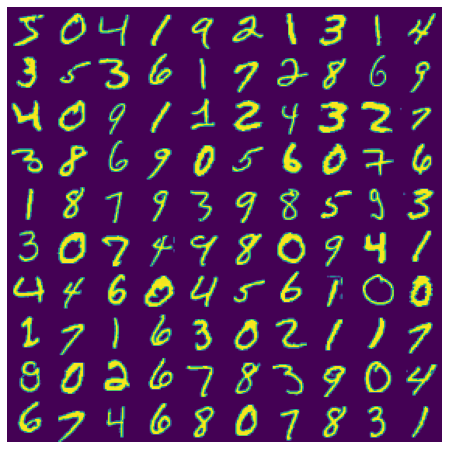

In [65]:
# plot a grid of images
def create_grid(X, n):
    """
    Creates a n-by-n grid from the first n**2 images of dataset X.
    
    args:
        X: np.array shaped (n_obs, height, width) containing images
        n: int: number of images in each row & column of the grid
    
    returns:
        np.array shapoed (n**2, height, width)
    """
    N = n**2
    X_grid = X[:N]
    indices = [(i, i+n) for i in range(0, N, n)]
    grid = np.concatenate(
        [np.concatenate(X_grid[i:j], axis=1) for i, j in indices]
    )
    return grid

grid = create_grid(X=X_train, n=10)

plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.axis("off")
plt.show()

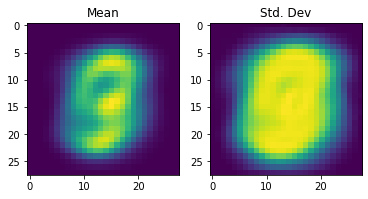

In [75]:
# compute the mean & std for each cell across all training images
#
# the mean image tells you how the average image looks like
#
# the std image tells you in what areas we observe the most 
# similarities across images, and in what areas we observe the most
# differences. 

# As expected, in MNIST, the most similarity across images
# is at the corners, since the handwritten digit is placed somewhere
# in the middle, surrounded by darkness.

mean_img = np.mean(X_train, axis=0)
sd_img = np.std(X_train, axis=0)

fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(mean_img)
plt.title("Mean")
fig.add_subplot(1, 2, 2)
plt.imshow(sd_img)
plt.title("Std. Dev")
plt.show(block=True)

In [81]:
# a simple pytorch neural net
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        """
        Args:
            x: torch.array shaped (batch_size, height, width)
        """
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

In [109]:
# initialize pytorch neural network
net = Net()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

print(net)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (act): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [116]:
# Run a single image through the network
x = X_train[0]
x = x.reshape((1, -1)) # first dimension is always batch_size
x = torch.tensor(x, dtype=torch.float32)

y = y_train[0]
y = y.reshape((-1)) # y must have dimension [batch_size]
y = torch.tensor(y, dtype=torch.long)

net.zero_grad()
out = net(x)
loss = loss_func(out, y)
loss.backward()

print((x.shape, y.shape))
print((out.shape, y.shape))
print(out)
print(loss)

(torch.Size([1, 784]), torch.Size([1]))
(torch.Size([1, 10]), torch.Size([1]))
tensor([[-0.0080, -0.0042,  0.0885, -0.0100,  0.0261,  0.0532,  0.1211, -0.0650,
         -0.0331, -0.1280]], grad_fn=<AddmmBackward>)
tensor(2.2558, grad_fn=<NllLossBackward>)


In [ ]:
# training the network
net.zero_grad()
out.backward()